In [71]:
# uses first sheet of scb excel

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import scipy.stats as sps

sns.set()

In [72]:
def parse_scb_prel():
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=' ')
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    df = df.loc[df['2020'] != 0]
    df = df.drop('Månad',axis=1)
    
    known_death_day = df.iloc[:,:7].sum()
    
    year_fraction = len(df) / 366
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] * year_fraction
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    index = pd.date_range('2020-01-01',periods=len(all_deaths))
    all_deaths.index = index
    
    return all_deaths
    
    

In [73]:
# days with k homicides in UK
zeros = np.array([0] * 259)
ones = np.array([1] * 387)
twos = np.array([2] * 261)
threes = np.array([3] * 131)
fours = np.array([4] * 40)
fives = np.array([5] * 13)
six = np.array([6] * 3)

data = np.concatenate([zeros,ones,twos,threes,fours,fives,six])


In [74]:
data_mean = data.mean()
data_std = data.std()
print (data_mean)
print (data_std)

1.4122486288848264
1.171366125502726


In [75]:
samples = pm.rpoisson(data_mean,100000)

[24265 34383 24491 11420  4008  1100   269    52    11     1]
[ 0  1  2  3  4  5  6  7  8  9 10] [259 387 261 131  40  13   3   0   0   0]
[259 387 261 131  40  13   3   0   0   0]


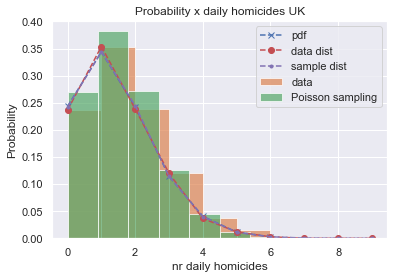

In [76]:
counts,bins = np.histogram(data,bins=range(0,11))
sample_counts,sample_bins=np.histogram(samples,bins=range(0,11))
print (sample_counts)
norm_sample_counts = sample_counts / sample_counts.sum()

x = range(7)
y = sps.poisson.pmf(x,data_mean)
plt.title('Probability x daily homicides UK')
plt.plot(x,y,'x--',label='pdf')
plt.hist(data,bins=6,density=True,alpha=0.7,label='data')
plt.hist(samples,bins=10,density=True,alpha=0.7,label='Poisson sampling')
print (bins,counts)
norm_counts = counts / counts.sum()
print (counts)
plt.plot(range(len(norm_counts)),norm_counts,'o--',label='data dist')
plt.plot(range(len(norm_sample_counts)),norm_sample_counts,'.--',label='sample dist')
plt.ylabel('Probability')
plt.xlabel('nr daily homicides')
plt.legend(loc='upper right')

In [77]:
scb = parse_scb_prel()
scb

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-01,298.059041,250.370762,347.270388,282.454201,309.086732,260.628770,297.585813
2020-01-02,274.820539,277.962641,324.733667,320.457130,284.359794,307.829256,296.563181
2020-01-03,283.913866,299.422992,317.562892,302.996325,279.208348,262.680965,296.563181
2020-01-04,258.654625,265.699584,312.440910,292.725263,290.541528,279.098525,284.291601
2020-01-05,270.779061,265.699584,311.416513,298.887900,283.329505,271.915842,286.336864
...,...,...,...,...,...,...,...
2020-08-03,217.229470,209.493903,201.806096,247.532591,228.724182,175.462676,220.888438
2020-08-04,226.322797,250.370762,210.001267,258.830759,200.906376,143.653653,229.069492
2020-08-05,231.374645,231.976175,226.391610,225.963361,222.542447,73.879021,228.046860
2020-08-06,217.229470,218.691196,221.269628,205.421237,237.996784,33.861218,219.865807


In [78]:
scb.loc[:'2020-07-31'].sum()

2015         54692.318451
2016         53397.440952
2017         54685.354340
2018         55556.173621
2019         51896.692634
2020         58302.861010
2015-2019    54240.383185
dtype: float64

In [79]:
last_data_day = scb.index[-1]
last_data_day

Timestamp('2020-08-07 00:00:00', freq='D')

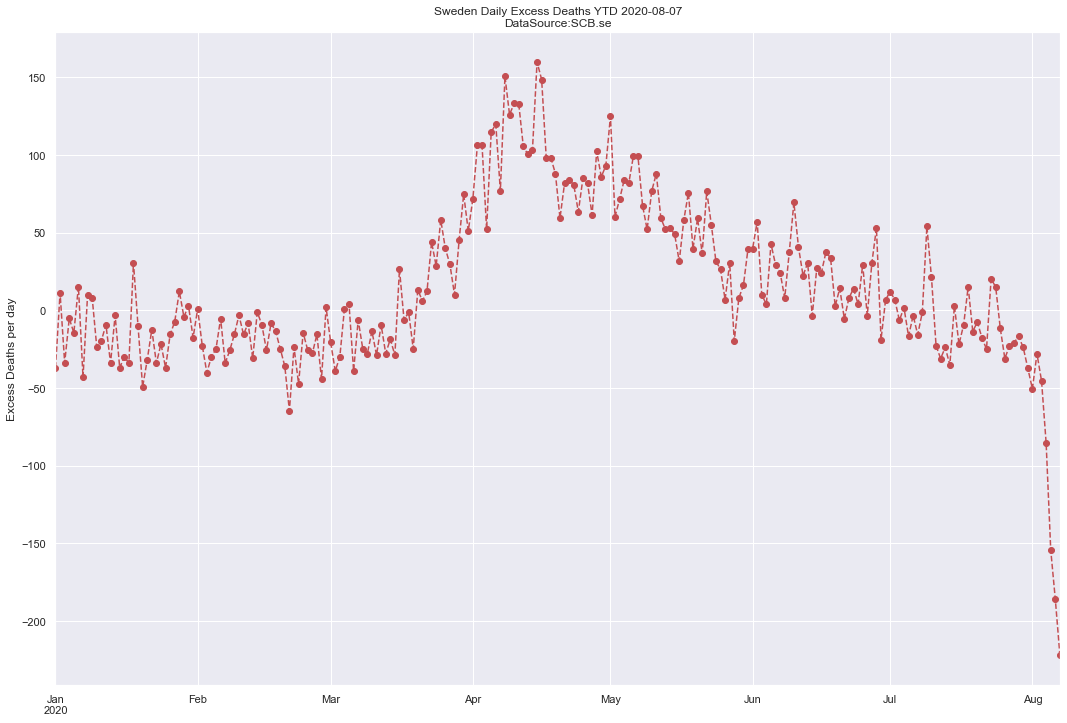

In [80]:
day_excess = scb['2020'][:last_data_day] - scb['2015-2019'][:last_data_day]
idx = day_excess.index.date
day_excess.plot(x=idx,figsize=(18,12),style='ro--',
               title='Sweden Daily Excess Deaths YTD {}\nDataSource:SCB.se'.format(last_data_day.date()))
plt.ylabel('Excess Deaths per day')

plt.savefig('scb_excess_deaths_per_day.jpg',format='jpg')

In [81]:
cumulative_until_last_day = scb[:last_data_day].sum()
cumulative_until_last_day['2020'] / cumulative_until_last_day['2015-2019']

1.0589359816448205

In [82]:
scb_weekly = scb.resample('W-TUE').sum()
print(scb_weekly.loc[:last_data_day].sum())
(scb_weekly.loc[:last_data_day,'2020'] - scb_weekly.loc[:last_data_day,'2015-2019']).sum()

2015         55569.319290
2016         54326.367574
2017         55598.091554
2018         56592.523763
2019         52781.710978
2020         59021.129273
2015-2019    55167.910100
dtype: float64


3853.2191732501346

In [83]:
scb_weekly

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-07,1957.085974,1886.467044,2245.476963,2052.158160,2024.518096,1927.011140,2034.014369
2020-01-14,1974.262257,1945.738490,2160.452060,1993.613108,1856.580972,1915.724067,1986.973313
2020-01-21,1957.085974,2012.163386,2138.939735,1997.721532,1887.489645,1837.740656,1999.244893
2020-01-28,1949.003017,2020.338758,1968.889928,1980.260727,1861.732417,1840.818948,1956.294363
2020-02-04,1986.386693,1973.330370,1959.670360,1904.254870,1927.670920,1840.818948,1951.181205
2020-02-11,1937.888951,1954.935783,1877.718646,2036.751568,1902.943982,1818.244803,1941.977520
2020-02-18,2071.257742,1822.085991,2052.890435,2078.862921,1807.127095,1869.549679,1966.520680
2020-02-25,2171.284335,1915.080846,2121.524996,2173.356690,1906.034849,1821.323096,2057.534898
2020-03-03,1761.074265,1845.590185,1793.718140,1927.878312,1539.251927,1796.696755,1971.633838
2020-03-10,2049.029610,1938.585040,1918.694503,2281.202840,1741.188592,1878.784557,1984.928050


In [84]:
scb_weekly.loc[:'2020-07-31'].sum()

2015         53999.204885
2016         52717.863171
2017         54039.984592
2018         54814.602954
2019         51245.549918
2020         57698.489571
2015-2019    53558.287869
dtype: float64

In [85]:
scb_weekly['excess'] = scb_weekly['2020'] - scb_weekly['2015-2019']
scb_weekly['cumexcess'] = scb_weekly['excess'].cumsum()
scb_weekly

,2015,2016,2017,2018,2019,2020,2015-2019,excess,cumexcess
2020-01-07,1957.085974,1886.467044,2245.476963,2052.158160,2024.518096,1927.011140,2034.014369,-107.003229,-107.003229
2020-01-14,1974.262257,1945.738490,2160.452060,1993.613108,1856.580972,1915.724067,1986.973313,-71.249246,-178.252475
2020-01-21,1957.085974,2012.163386,2138.939735,1997.721532,1887.489645,1837.740656,1999.244893,-161.504237,-339.756712
2020-01-28,1949.003017,2020.338758,1968.889928,1980.260727,1861.732417,1840.818948,1956.294363,-115.475415,-455.232127
2020-02-04,1986.386693,1973.330370,1959.670360,1904.254870,1927.670920,1840.818948,1951.181205,-110.362257,-565.594384
2020-02-11,1937.888951,1954.935783,1877.718646,2036.751568,1902.943982,1818.244803,1941.977520,-123.732717,-689.327101
2020-02-18,2071.257742,1822.085991,2052.890435,2078.862921,1807.127095,1869.549679,1966.520680,-96.971001,-786.298102
2020-02-25,2171.284335,1915.080846,2121.524996,2173.356690,1906.034849,1821.323096,2057.534898,-236.211802,-1022.509904
2020-03-03,1761.074265,1845.590185,1793.718140,1927.878312,1539.251927,1796.696755,1971.633838,-174.937083,-1197.446987
2020-03-10,2049.029610,1938.585040,1918.694503,2281.202840,1741.188592,1878.784557,1984.928050,-106.143493,-1303.590480


In [86]:
scb_monthly = scb.resample('M').sum()
scb_monthly['delta'] = scb_monthly['2020'] - scb_monthly['2015-2019']
scb_monthly['cumdelta'] = (scb_monthly['delta'].cumsum())
# last of feb not correct for delta - leap year
scb_monthly

,2015,2016,2017,2018,2019,2020,2015-2019,delta,cumdelta
2020-01-31,8726.562496,8735.384775,9323.031861,8810.516867,8421.583165,8331.911851,8805.881214,-473.969363,-473.969363
2020-02-29,8150.651807,7840.181562,8067.121844,8371.942525,7514.928750,7554.129932,8188.211692,-634.081760,-1108.051123
2020-03-31,8708.375843,8184.569100,8273.025526,9459.647977,7799.288544,8582.279646,8483.752242,98.527404,-1009.523719
2020-04-30,7773.783935,7568.350450,7750.583349,7821.413609,7403.657527,10637.552976,7663.601651,2973.951324,1964.427606
2020-05-31,7386.812366,7144.253037,7510.874586,6961.725731,7183.175658,8927.048412,7235.118986,1691.929426,3656.357032
2020-06-30,6837.171287,6685.410295,6817.358206,6675.163105,6647.425322,7404.319695,6733.006842,671.312853,4327.669885
2020-07-31,7108.960718,7239.291734,6943.358967,7455.763807,6926.633670,6865.618497,7130.810557,-265.192060,4062.477825
2020-08-31,1532.730729,1608.504403,1599.082819,1681.372827,1590.766382,831.138990,1602.463809,-771.324819,3291.153005


In [87]:
scb_monthly.loc[:'2020-07-31'].sum()

2015         54692.318451
2016         53397.440952
2017         54685.354340
2018         55556.173621
2019         51896.692634
2020         58302.861010
2015-2019    54240.383185
delta         4062.477825
cumdelta     11419.388143
dtype: float64

In [88]:
scb_monthly.loc[:'2020-07-31'].sum()['2020'] / 10.327589

5645.350624418796

In [89]:
data = scb_weekly.iloc[:,0:5]
#data = data.iloc[:9]
data.mean(axis=1)
data

,2015,2016,2017,2018,2019
2020-01-07,1957.085974,1886.467044,2245.476963,2052.158160,2024.518096
2020-01-14,1974.262257,1945.738490,2160.452060,1993.613108,1856.580972
2020-01-21,1957.085974,2012.163386,2138.939735,1997.721532,1887.489645
2020-01-28,1949.003017,2020.338758,1968.889928,1980.260727,1861.732417
2020-02-04,1986.386693,1973.330370,1959.670360,1904.254870,1927.670920
2020-02-11,1937.888951,1954.935783,1877.718646,2036.751568,1902.943982
2020-02-18,2071.257742,1822.085991,2052.890435,2078.862921,1807.127095
2020-02-25,2171.284335,1915.080846,2121.524996,2173.356690,1906.034849
2020-03-03,1761.074265,1845.590185,1793.718140,1927.878312,1539.251927
2020-03-10,2049.029610,1938.585040,1918.694503,2281.202840,1741.188592


In [90]:
data_min = data.min(axis=1)
data_max = data.max(axis=1)

print (data.mean().mean())

1739.0027322404374


[1.56118242e-02 4.93396653e+02 1.19689481e+03 2.40883981e+03
 1.79109817e+04]


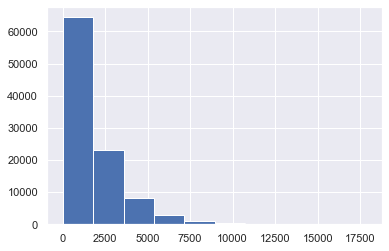

In [91]:
test_lambda = pm.rexponential(1/ data.mean().mean(),100000)
plt.hist(test_lambda)
print (np.percentile(test_lambda,[0,25,50,75,100]))

In [92]:
walk = 50000
burnin = 20000
thin = 2


res_array = np.zeros((len(data),3))
dist_array = np.zeros((len(data),(walk - burnin) // thin))

for i in range(len(data)):
    print ('\n++++++++++++++++++++ processing day ++++++++++++++++++++', i)
    print (data.iloc[i,:])
    print (data.iloc[i,:].mean())
    
    lambda_ = pm.Exponential('lambda',1/ data.iloc[i,:].mean())
    lkh  = pm.Poisson('lkh',lambda_,observed=True,value=data.iloc[i,:])
    model = pm.Model([lambda_,lkh])
    mcmc = pm.MCMC(model)
    sample = mcmc.sample(walk,burnin,thin)
    post = mcmc.trace(lambda_)[:]   
        
    res_array[i,0] = post.min()
    res_array[i,1] = post.mean()
    res_array[i,2] = post.max()
    
    dist_array[i,:] = post
                     
    


++++++++++++++++++++ processing day ++++++++++++++++++++ 0
2015    1957.085974
2016    1886.467044
2017    2245.476963
2018    2052.158160
2019    2024.518096
Name: 2020-01-07 00:00:00, dtype: float64
2033.1412475024713
 [-----------------100%-----------------] 50000 of 50000 complete in 2.0 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 1
2015    1974.262257
2016    1945.738490
2017    2160.452060
2018    1993.613108
2019    1856.580972
Name: 2020-01-14 00:00:00, dtype: float64
1986.1293772846577
 [-----------------100%-----------------] 50000 of 50000 complete in 3.5 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 2
2015    1957.085974
2016    2012.163386
2017    2138.939735
2018    1997.721532
2019    1887.489645
Name: 2020-01-21 00:00:00, dtype: float64
1998.6800543375866
 [-----------------100%-----------------] 50000 of 50000 complete in 2.5 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 3
2015    1949.003017
2016    2020.338758
2017    1

 [-----------------100%-----------------] 50000 of 50000 complete in 2.3 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 28
2015    1530.709990
2016    1609.526324
2017    1578.594890
2018    1766.622641
2019    1526.888457
Name: 2020-07-21 00:00:00, dtype: float64
1602.4684604847787
 [-----------------100%-----------------] 50000 of 50000 complete in 2.6 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 29
2015    1579.207732
2016    1714.784236
2017    1505.862744
2018    1683.427039
2019    1559.857709
Name: 2020-07-28 00:00:00, dtype: float64
1608.6278921736562
 [-----------------100%-----------------] 50000 of 50000 complete in 2.5 sec
++++++++++++++++++++ processing day ++++++++++++++++++++ 30
2015    1570.114405
2016    1608.504403
2017    1558.106962
2018    1777.920809
2019    1536.161059
Name: 2020-08-04 00:00:00, dtype: float64
1610.1615276097975
 [-----------------100%-----------------] 50000 of 50000 complete in 2.6 sec
++++++++++++++++++++ processi

In [93]:
dist_array

array([[2030.62173705, 2018.68064145, 2000.31743923, ..., 1992.977673  ,
        1989.2470403 , 2034.80758412],
       [2032.08908088, 2026.25347489, 1977.69969175, ..., 1985.33884322,
        1985.33884322, 1950.58357113],
       [1997.53378141, 1997.53378141, 1984.74196824, ..., 1990.40416299,
        2000.84956343, 2000.84956343],
       ...,
       [1619.64022399, 1619.64022399, 1614.83300553, ..., 1617.22869886,
        1617.22869886, 1632.34695576],
       [1628.16740815, 1628.16740815, 1628.16740815, ..., 1568.10696401,
        1568.10696401, 1623.25158566],
       [ 686.95839948,  670.69483795,  670.69483795, ...,  675.91926604,
         675.91926604,  675.91926604]])

In [94]:
N = 1000

lambdas_per_week = np.zeros((len(dist_array),N))
samples_per_week = np.zeros((len(dist_array),N))

for week in range(len(dist_array)):
    lambdas_per_week[week] = np.random.choice(dist_array[week],replace=True,size=N)
    samples_per_week[week] = pm.rpoisson(lambdas_per_week[week],size=N)

In [95]:
print (lambdas_per_week[:5])
samples_per_week[:5]

[[1996.95123337 2050.53759345 2044.44905315 ... 2077.838107
  2011.00440298 2025.04523152]
 [1975.42660616 1974.81747197 1974.52795512 ... 1984.23576153
  1999.16289576 1966.2589307 ]
 [2012.22811713 1995.09887713 1988.71933019 ... 2004.99739926
  1968.75550225 1995.68552955]
 [1950.13979163 1940.3132441  1951.03668517 ... 1953.86971005
  1942.99394731 1928.5987503 ]
 [1916.83830684 1920.09515944 1964.13105226 ... 1965.63814517
  1910.25104672 1929.29086755]]


array([[1984., 2003., 2076., ..., 2120., 2011., 2057.],
       [1975., 1995., 2053., ..., 2049., 1942., 1974.],
       [2024., 1929., 1978., ..., 1964., 1915., 2024.],
       [1975., 1941., 2013., ..., 1921., 1938., 1921.],
       [1894., 1919., 1943., ..., 1981., 1943., 1952.]])

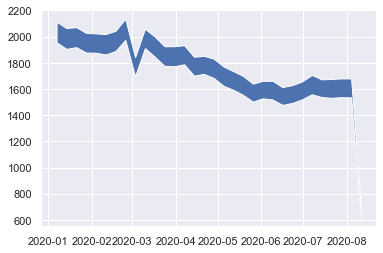

In [96]:
ci_samples = np.percentile(samples_per_week,[5.5,94.5],axis=1)
ci_samples

plt.fill_between(scb_weekly.index,ci_samples[0],ci_samples[1])

In [97]:
res_array

array([[1959.54822241, 2033.49792881, 2113.86071028],
       [1913.45575445, 1985.57695037, 2056.22004452],
       [1922.84254349, 1997.71357623, 2070.25591251],
       [1883.03608348, 1955.57134472, 2029.50048349],
       [1880.57655976, 1949.31375325, 2029.66000463],
       [1867.90681913, 1941.64135619, 2027.89253749],
       [1890.61820416, 1966.27249998, 2043.97186545],
       [1981.95125114, 2056.89729634, 2139.04994191],
       [1706.0750988 , 1772.60967871, 1839.94802959],
       [1913.10208186, 1985.75585928, 2069.04369559],
       [1855.8523859 , 1923.06161953, 2004.56320044],
       [1780.38133548, 1853.51519977, 1930.55516127],
       [1779.04469996, 1849.19628057, 1921.67140101],
       [1792.79050095, 1863.72193615, 1933.17445788],
       [1706.57458283, 1775.63510329, 1854.62351619],
       [1710.56956019, 1786.41279602, 1852.76010988],
       [1690.41021653, 1756.36703532, 1831.1224306 ],
       [1633.35156858, 1699.13648334, 1770.29490162],
       [1582.27951415, 1665.

In [98]:
errors_low = np.abs(res_array[:,1] - res_array[:,0])
errors_low = errors_low[:-1]
errors_high = np.abs(res_array[:,1] - res_array[:,2]) 
errors_high = errors_high[:-1]
print (errors_low)
print (errors_high)

errors = np.array((errors_low,errors_high))
errors

[73.9497064  72.12119593 74.87103274 72.53526125 68.73719349 73.73453705
 75.65429582 74.9460452  66.53457992 72.65377742 67.20923363 73.13386429
 70.15158061 70.93143519 69.06052046 75.84323582 65.95681879 65.78491476
 83.52548857 85.47386746 63.4520074  66.88339108 66.87152923 56.36085162
 65.74420258 64.15701009 65.79647494 71.43610671 63.28677605 81.46052306
 73.53738347]
[80.36278147 70.64309415 72.54233628 73.92913876 80.34625137 86.25118131
 77.69936548 82.15264556 67.33835088 83.28783631 81.5015809  77.0399615
 72.47512044 69.45252174 78.9884129  66.34731387 74.75539529 71.15841829
 71.7714651  83.77955121 70.8892128  62.5019852  69.36521697 73.89510316
 64.31270242 66.84154335 74.04784862 66.58031317 68.4476506  68.97973484
 74.13043036]


array([[73.9497064 , 72.12119593, 74.87103274, 72.53526125, 68.73719349,
        73.73453705, 75.65429582, 74.9460452 , 66.53457992, 72.65377742,
        67.20923363, 73.13386429, 70.15158061, 70.93143519, 69.06052046,
        75.84323582, 65.95681879, 65.78491476, 83.52548857, 85.47386746,
        63.4520074 , 66.88339108, 66.87152923, 56.36085162, 65.74420258,
        64.15701009, 65.79647494, 71.43610671, 63.28677605, 81.46052306,
        73.53738347],
       [80.36278147, 70.64309415, 72.54233628, 73.92913876, 80.34625137,
        86.25118131, 77.69936548, 82.15264556, 67.33835088, 83.28783631,
        81.5015809 , 77.0399615 , 72.47512044, 69.45252174, 78.9884129 ,
        66.34731387, 74.75539529, 71.15841829, 71.7714651 , 83.77955121,
        70.8892128 , 62.5019852 , 69.36521697, 73.89510316, 64.31270242,
        66.84154335, 74.04784862, 66.58031317, 68.4476506 , 68.97973484,
        74.13043036]])

2020-01-07   -107.003229
2020-01-14    -71.249246
2020-01-21   -161.504237
2020-01-28   -115.475415
2020-02-04   -110.362257
2020-02-11   -123.732717
2020-02-18    -96.971001
2020-02-25   -236.211802
2020-03-03   -174.937083
2020-03-10   -106.143493
2020-03-17    -93.012177
2020-03-24     78.110430
2020-03-31    308.968508
2020-04-07    648.655309
2020-04-14    852.547186
2020-04-21    734.587561
2020-04-28    559.024376
2020-05-05    601.915986
2020-05-12    542.291422
2020-05-19    359.524759
2020-05-26    292.651661
2020-06-02    171.631073
2020-06-09    156.229213
2020-06-16    211.485981
2020-06-23    104.823827
2020-06-30    101.825249
2020-07-07    -21.136626
2020-07-14    -38.684259
2020-07-21    -52.033925
2020-07-28    -75.613372
2020-08-04   -286.982529
Freq: W-TUE, dtype: float64
2020-01-07    -107.003229
2020-01-14    -178.252475
2020-01-21    -339.756712
2020-01-28    -455.232127
2020-02-04    -565.594384
2020-02-11    -689.327101
2020-02-18    -786.298102
2020-02-25   -1

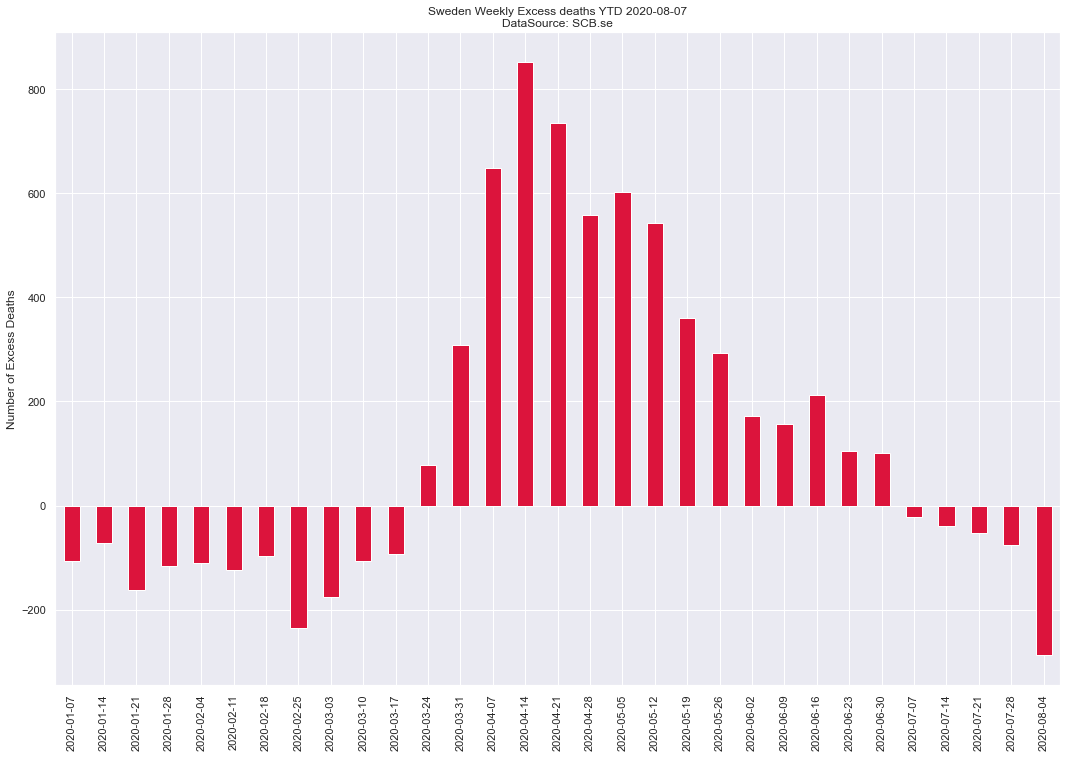

In [116]:
excess = scb_weekly.loc[:last_data_day,'2020'] - scb_weekly.loc[:last_data_day,'2015-2019']
print (excess)
current_excess = excess.cumsum()
print (current_excess)
excess.index = excess.index.date
excess.plot.bar(x=excess.index,title='Sweden Weekly Excess deaths YTD {}\nDataSource: SCB.se'.format(last_data_day.date()),
                y=excess,
                figsize=(18,12),
                color='crimson')
plt.ylabel('Number of Excess Deaths')
plt.savefig('swe_excess_deaths.jpg',format='jpg',dpi=400)

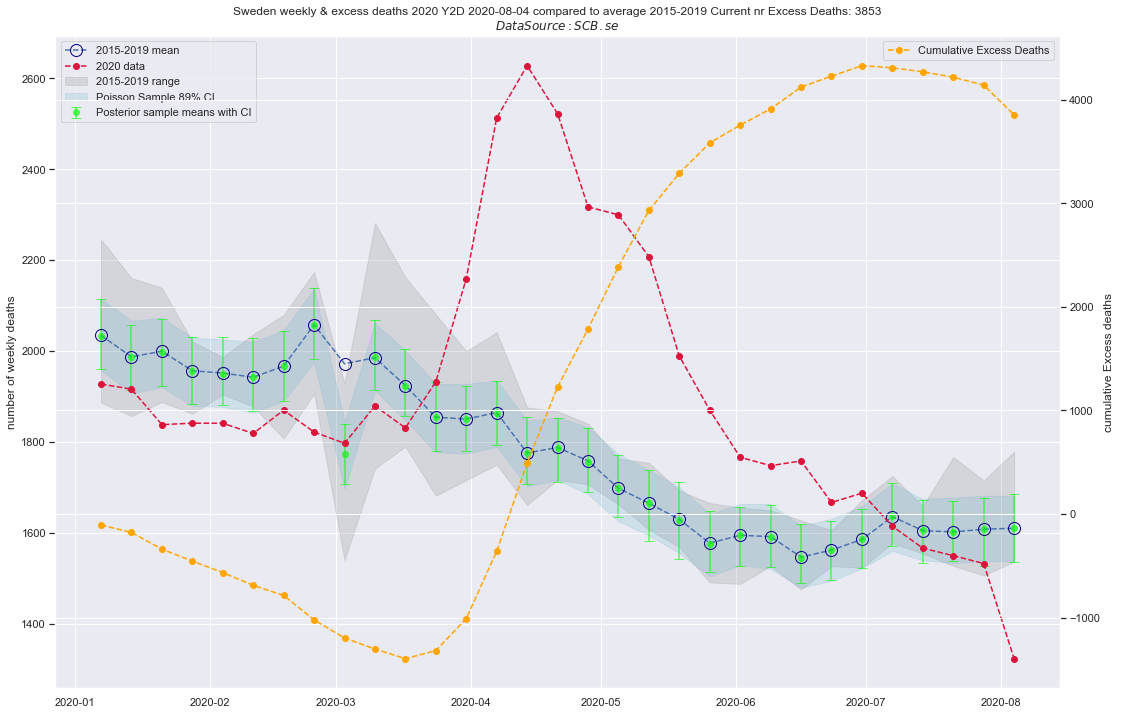

In [117]:
plt.figure(figsize=(18,12))
plt.title('Sweden weekly & excess deaths 2020 Y2D '\
          '{} compared to average 2015-2019 Current nr Excess Deaths: {}\n$Data Source: SCB.se$'.format(
    excess.index[-1],int(current_excess[-1])))
ax = plt.gca()
ax2 = plt.twinx()

ax.errorbar(scb_weekly.index[:len(data) - 1],res_array[:-1,1],yerr=errors,
             fmt='o',capsize=5,color='lime',alpha=0.6,label='Posterior sample means with CI')

ax.plot(scb_weekly.index[:len(data) -1],scb_weekly['2015-2019'][:-1],'o--',
        markerfacecolor='none',markeredgecolor='navy',markersize=12,
        label='2015-2019 mean')

ax.plot(scb_weekly[:last_data_day].index,scb_weekly.loc[:last_data_day,'2020'],'o--',
         color='crimson',label='2020 data')

ax.fill_between(scb_weekly.index[:len(data) -1],y1=data_min[:-1],y2=data_max[:-1],color='grey',
                 alpha=0.2,label='2015-2019 range')

ax.fill_between(scb_weekly.index[:len(data) -1],y1=ci_samples[0][:-1],y2=ci_samples[1][:-1],color='c',
                 alpha=0.2,label='Poisson Sample 89% CI')



ax2.plot(excess.index,excess.cumsum(),'o--',ls='dashed',color='orange',label='Cumulative Excess Deaths')
ax.set_ylabel('number of weekly deaths')
ax2.set_ylabel('cumulative Excess deaths')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('scb_poisson_weekly.jpg',format='jpg',dpi=400)

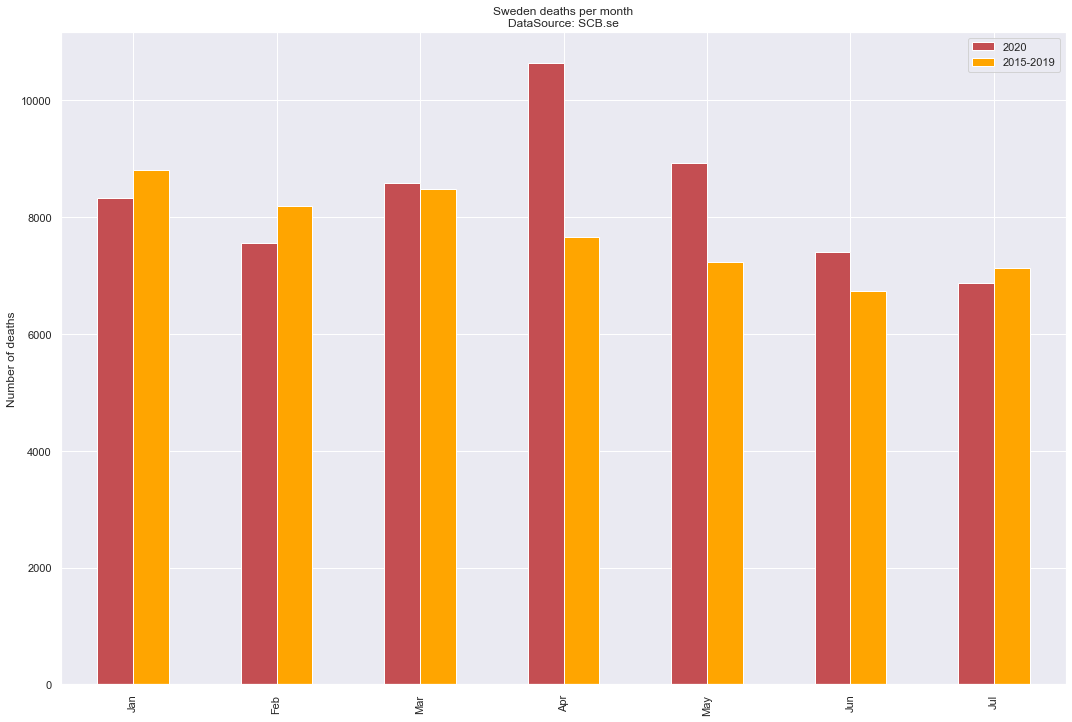

In [101]:
#scb_monthly.index = scb_monthly.index.date
scb_monthly[['2020','2015-2019']][:pd.Timestamp('2020-07-31')].plot.bar(color=['r','orange'],
                                                                        title='Sweden deaths per month\nDataSource: SCB.se',figsize=(18,12))
plt.ylabel('Number of deaths')
plt.xticks(range(len(scb_monthly[:pd.Timestamp('2020-07-31')])),['Jan','Feb','Mar','Apr','May','Jun','Jul'])
plt.savefig('scb_monthly_deaths.jpg',format='jpg')